<a href="https://colab.research.google.com/github/Tclack88/MountainProject/blob/master/HangboardProgress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO:
Correct datetime formatting in plotly (tickformat doesn't seem to work)

In [1]:
import datetime as dt
from numpy import log
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# df = pd.read_excel('MorganHB1.xlsx')
# df = pd.read_excel('TrevorHB.xlsx')
# doc = 'https://github.com/Tclack88/MountainProject/blob/master/MorganHB.xlsx?raw=true'
# doc = 'https://github.com/Tclack88/MountainProject/blob/master/TrevorHB.xlsx?raw=true'
# doc = 'https://github.com/Tclack88/MountainProject/blob/master/TrevorHB_maxhangs.xlsx?raw=true'
docs = ['https://github.com/Tclack88/MountainProject/blob/master/TrevorHB_kg.xlsx?raw=true','https://github.com/Tclack88/MountainProject/blob/master/TrevorHB_lb.xlsx?raw=true']

In [2]:
def split_dfs(df):
  #
  # NOTE: THIS DEFINITION WAS WRITTEN HEAVILY USING ChatGPT.
  #
  # Partially it was me testing the software (it's amazing!)
  # partially it's just a long, annoying problem I wanted to save time
  #
  # Makes two separate dfs. One for one handed, and one for two handed measurements
  # i.e. some entries will be "R,-,-,-,-:L,-,-,-,-"
  # I want those in their own (one_hand_df)
  # The rest go in two_hand_df and are processed normally
  regular_cols = [col for col in df.columns if ':' not in ''.join(df[col])] # may need .join(df[col].astype(str)). Check later
  one_hand_df = df.loc[df.apply(lambda x: ':' in x.to_string(), axis=1), df.columns.difference(regular_cols)] # get only the values containing ":"
  two_hand_df = df.applymap(lambda x: np.nan if ':' in str(x) else x) # replace all "cells" containing ":" with a NaN

  # one_hand_df is not complete. I have one column now with the "R,-,-,-,-:L,-,-,-,-" entires
  # This next section will split them up and rename the columns into
  #   grip_R          grip_L
  #  "R,-,-,-,-"    "L,-,-,-,-"

  # Create a new DataFrame to hold the split values
  split_df = pd.DataFrame()
  # Loop over each column in one_hand_df and split on the colon
  for col in one_hand_df.columns:
      # Create new columns for each side of the colon
      split_cols = [col + '_R', col + '_L']
      # Apply a lambda function to split on the colon and fillna with empty strings
      split_data = one_hand_df[col].apply(lambda x: pd.Series(x.split(':'))).fillna('')
      # Rename the columns to include _R and _L
      split_data.columns = split_cols
      # Add the split data to the split_df DataFrame
      split_df[split_cols] = split_data

  # Combine the split_df and one_hand_df DataFrames
  one_handsplit_df = pd.concat([one_hand_df.index.to_frame(), split_df], axis=1).drop(columns = ['date'])
  one_handsplit_df = one_handsplit_df.applymap(lambda x: ",".join(x.split(",")[1:])) # remove the leading "L" and "R" from each cell
  return two_hand_df,one_handsplit_df

# two, one = split_dfs(df)

In [3]:
def to_lb(vals):
  # 1 kg = 2.2046 lb
  try:
    weight = str(round(float(vals.split(',')[0])*2.2046,1)) # round to 1 decimal place
    times = vals.split(',')[1:]
    return ','.join([weight]+times) # recombine as original string and return
  except:
    return np.nan

def to_kg(vals):
  # 1 kg = 2.2046 lb
  try:
    weight = str(round(float(vals.split(',')[0])/2.2046,1)) # round to 1 decimal place
    times = vals.split(',')[1:]
    return ','.join([weight]+times) # recombine as original string and return
  except:
    return np.nan

def preprocess_hangboard(docs, display_unit='lb'):
  # Initial processing of excel doc
  two = pd.DataFrame()
  one = pd.DataFrame()
  for doc in docs:
    df = pd.read_excel(doc)
    df.date = pd.to_datetime(df.date)
    df.date = pd.to_datetime(df.date, format = '%d %b %Y')
    df = df.set_index('date')
    two_i, one_i = split_dfs(df)
    # Convert units if applicable:
    unit = doc.split('/')[-1].split('.')[0][-2:] # returns kg or lb. Same assumption as described in "name" variable
    if unit == display_unit:
      pass
    else:
      if display_unit == 'kg':
        one_i = one_i.applymap(to_kg)
        two_i = two_i.applymap(to_kg)
      elif display_unit == 'lb':
        one_i = one_i.applymap(to_lb)
        two_i = two_i.applymap(to_lb)
    two = pd.concat([two,two_i]).sort_index()
    one = pd.concat([one,one_i]).sort_index()
  name = doc.split('/')[-1].split('.')[0][:-5] # cheap way of getting climber name under assumption it's saved as "nameHB_kg" or "nameHB_lb"
  today = dt.datetime.today().strftime('%d %b %Y')
  return name, today, two, one, display_unit

def process_hangboard_for_plot(df, HANGTIME, N_ROUNDS):
  # Create new df ready for plot
  cols = df.columns
  hangs = []
  for col in cols:
    column = df[col]
    inner_df = column.str.split(',', expand=True)#.fillna(0) # looks like an error happens if I don't first do this, pardon the redundancy. fillna temporarily removed for testing. I may want it now for when one and two handed splits exists
    if len(inner_df.columns) == 2:
      inner_df[2] = 0
      inner_df[3] = HANGTIME*N_ROUNDS
      inner_df[4] = 0
    else:
      inner_df[1] = inner_df[1].apply(pd.to_numeric) # change to numeric columns
      # print(inner_df.dtypes)
      inner_df.insert(2, 'fail', N_ROUNDS - inner_df[1])
      inner_df.insert(3, 'TUT', HANGTIME*inner_df[1] + (inner_df.iloc[:,3:]).apply(pd.to_numeric).sum(axis=1))
      inner_df.insert(4, 'penalty_factor', log(N_ROUNDS + 1 - inner_df[1])/log(6)) #apply log base 6 as penalty factor (log(6,6) = 1.0 for failing all but one, log(6,1) = 0 for failing none
      inner_df = inner_df.iloc[:,:5]
    inner_df.columns = ['weight','success','fail','TUT','penalty_factor',]
    inner_df = inner_df[['weight','success','fail','TUT','penalty_factor']]
    inner_df = inner_df.apply(pd.to_numeric) # change to numeric columns
    inner_df.TUT = inner_df.TUT/(HANGTIME*N_ROUNDS) # change TUT (Time under tension to a fraction of ex. 60 seconds later for coloring)
    hang = inner_df[['weight','TUT','penalty_factor']]
    hang.index.name = 'Date'
    hang = hang.reset_index()
    hang['effective_weight'] = hang.weight - 2.5 * (hang.penalty_factor) - 2.5 * (1 - hang.TUT) # arbitrary penalty of 2.5 lbs for low TUT and penalty for low total successful reps
    hangs.append(hang)
  return hangs, cols, name, today

In [56]:
def plot_data(hangs,cols,name,today, display_unit):
  fig = go.Figure()

  ending_weights = []

  for hang in hangs:
    ending_weight = hang.effective_weight.to_list()[-1]
    ending_weights.append(ending_weight)
    fig.add_trace(go.Scatter(x=hang.index, y=hang.effective_weight, mode='lines+markers'))

  # Adding labels
  annotations = []
  for ending_weight, col in zip(ending_weights, cols):
      # labeling the right_side of the plot
      annotations.append(dict(xref='paper', x=1, y=ending_weight,
                                    xanchor='left', yanchor='middle',
                                    text=f'{col}',
                                    font=dict(family='Arial',
                                              size=12),
                                    showarrow=False))

  # Title
  annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                xanchor='left', yanchor='bottom',
                                text='Hangboard Progress',
                                font=dict(family='Arial',
                                          size=30,
                                          color='rgb(37,37,37)'),
                                showarrow=False))

  annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1,
                                xanchor='left', yanchor='bottom',
                                text=f'{name} - as of {today}',
                                font=dict(family='Arial',
                                          size=20,
                                          color='rgb(37,37,37)'),
                                showarrow=False))

  fig.update_layout(annotations=annotations,
                    width = 1400,
                    height=800,
                    showlegend=False, # alternatively can show legend (default to True) and remove label on right
                    xaxis = dict(
                        tickmode = 'array',
                        tickvals = hang.index,
                        ticktext = hang.Date,
                        tickformat = '%d'
                        ),
                    yaxis = dict(
                        tickmode = 'array',
                        title = f'weight ({display_unit})' #(removed from body weight)' #Technically wrong now. Could be added
                        ))
  # fig.update_layout(xaxis_tickformat = '%d %B (%a)<br>%Y')
  # fig.update_xaxes(tickvals=hang.index, ticktext=hang.Date, tickformat = "%d%b%Y")
  return fig

In [57]:
# change here 6 for repeaters, 2 for max hangs
HANGTIME, N_ROUNDS = 10,6

name, today, two, one, display_unit = preprocess_hangboard(docs,display_unit='lb')
# two, one = process_hangboard_for_plot(doc, HANGTIME, N_ROUNDS)

if not two.empty:
  hangs, cols, name, today = process_hangboard_for_plot(two, HANGTIME, N_ROUNDS)
  fig = plot_data(hangs,cols,name,today, display_unit)
  fig.show()

if not one.empty:
  hangs, cols, name, today = process_hangboard_for_plot(one, HANGTIME, N_ROUNDS)
  fig = plot_data(hangs,cols,name,today, display_unit)
  fig.show()

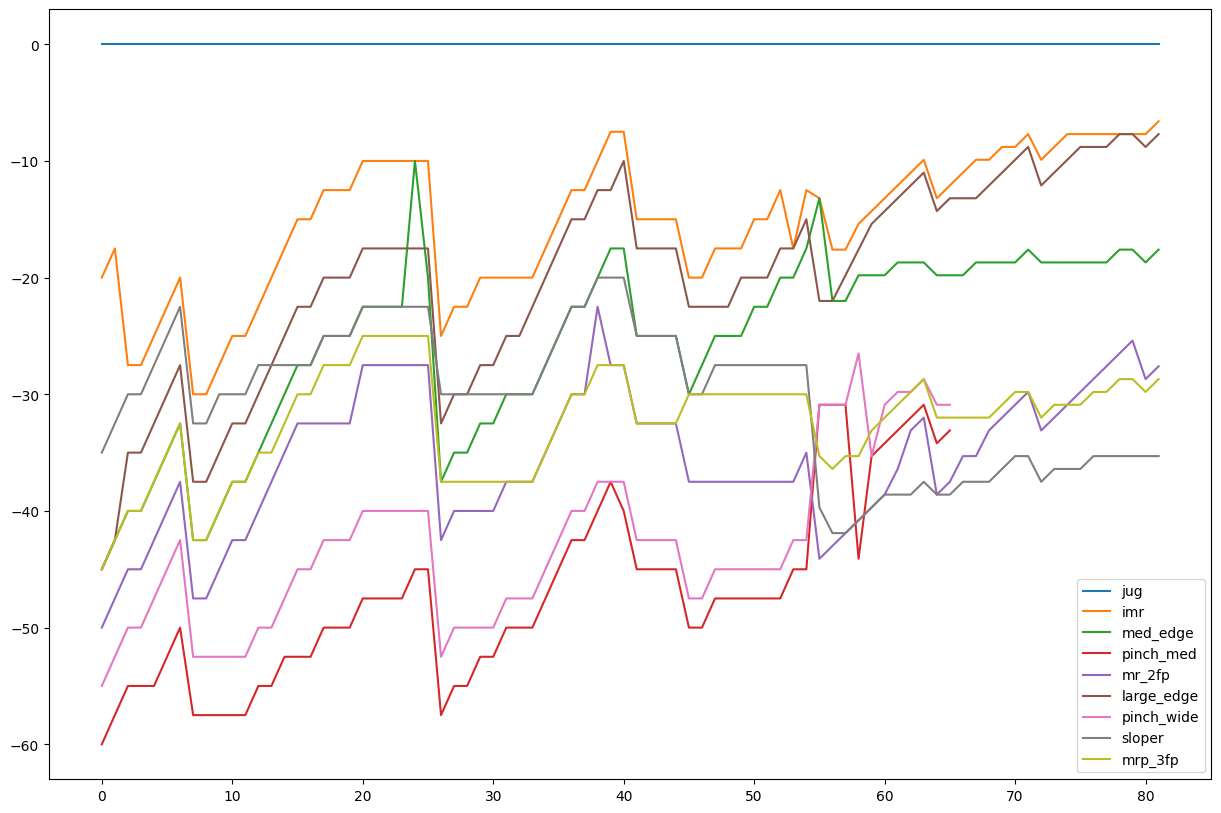

In [55]:
# With Seaborn
plt.figure(figsize=(15,10))
for hang in hangs:
  plt.plot(hang.index, hang.weight)

plt.legend(cols)
plt.show();